# DLPFC SEA-AD Oligodendrocyte Analysis

This notebook analyzes oligodendrocyte data from the SEA-AD dataset, specifically focusing on the dorsolateral prefrontal cortex (DLPFC) region and comparing different Braak stages.

## Objectives:
1. Load and inspect the OLIGO_DLPFC_SEA-AD.h5ad dataset
2. Check data normalization status
3. Filter for Braak stages: Reference, Braak 3, and Braak 6
4. Perform standard Scanpy processing if needed
5. Analyze cluster composition by Braak stage
6. Perform differential gene expression analysis
7. Visualize results with volcano plots


In [1]:
# Import required libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for modern Jupyter notebook display
# Use plt.rcParams instead of deprecated IPython.display.set_matplotlib_formats
plt.rcParams['figure.autolayout'] = True  # Prevents label overlapping
plt.rcParams['figure.dpi'] = 150  # Higher DPI for better resolution
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size
plt.rcParams['savefig.format'] = 'png'  # Default save format
plt.rcParams['savefig.dpi'] = 300  # High resolution for saved figures
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Set scanpy settings without using deprecated set_figure_params
sc.settings.verbosity = 3  # verbosity level
# Configure scanpy settings manually to avoid deprecated IPython function calls
sc.settings._vector_friendly = False
sc.settings.dpi = 150  # Match matplotlib DPI
sc.settings.dpi_save = 300
sc.settings.frameon = True
sc.settings.fontsize = 12
sc.settings.figsize = (10, 6)
sc.settings.color_map = 'viridis'

# Load environment variables
load_dotenv()

print("Libraries imported successfully!")
print("Matplotlib and Scanpy configured for modern Jupyter display")


/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWar

Libraries imported successfully!
Matplotlib and Scanpy configured for modern Jupyter display


In [2]:
# Load data path from environment variables
data_path = os.getenv('DATA_PATH')
if data_path is None:
    raise ValueError("DATA_PATH not found in environment variables. Please check your .env file.")

# Construct the full path to the data file
data_file_path = os.path.join(data_path, 'OLIGO_DLPFC_SEA-AD.h5ad')

print(f"Data path: {data_path}")
print(f"Data file path: {data_file_path}")

# Check if file exists
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"Data file not found at: {data_file_path}")

print("Data file found!")


Data path: /oak/stanford/groups/quake/LuiseSeeker/AD_oligos
Data file path: /oak/stanford/groups/quake/LuiseSeeker/AD_oligos/OLIGO_DLPFC_SEA-AD.h5ad
Data file found!


In [3]:
# Load the AnnData object
print("Loading AnnData object...")
adata = sc.read_h5ad(data_file_path)

print(f"Dataset shape: {adata.shape}")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# Display basic information about the dataset
print("\nDataset info:")
print(f"Obs (cells) columns: {list(adata.obs.columns)}")
print(f"Var (genes) columns: {list(adata.var.columns)}")

# Check if there are any uns keys
if adata.uns:
    print(f"Unstructured metadata keys: {list(adata.uns.keys())}")


Loading AnnData object...
Dataset shape: (145995, 36412)
Number of cells: 145995
Number of genes: 36412

Dataset info:
Obs (cells) columns: ['assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid']
Var (genes) columns: ['feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'featu

## Data Normalization Check

We need to check whether the data is normalized and if raw data is available for processing.


In [4]:
# Check data normalization status
print("Checking data normalization status...")

# Check if raw data is available
has_raw = adata.raw is not None
print(f"Raw data available: {has_raw}")

# Check the main data matrix properties
print(f"\nMain data matrix:")
print(f"  - Data type: {type(adata.X)}")
print(f"  - Shape: {adata.X.shape}")
print(f"  - Data type of values: {adata.X.dtype if hasattr(adata.X, 'dtype') else 'Unknown'}")

# Check for normalized data in layers
print(f"\nAvailable layers: {list(adata.layers.keys())}")

# Check data distribution to infer normalization status
sample_data = adata.X[:1000, :1000].toarray() if hasattr(adata.X, 'toarray') else adata.X[:1000, :1000]
print(f"\nData statistics (sample of 1000x1000):")
print(f"  - Min: {np.min(sample_data):.2f}")
print(f"  - Max: {np.max(sample_data):.2f}")
print(f"  - Mean: {np.mean(sample_data):.2f}")
print(f"  - Median: {np.median(sample_data):.2f}")

# Determine if data appears to be normalized
is_normalized = np.max(sample_data) < 50 and np.mean(sample_data) < 10
print(f"\nData appears to be normalized: {is_normalized}")

# Store raw data if available and data is normalized
if has_raw and is_normalized:
    print("Raw count data is available and will be used for processing.")
    # Keep the current normalized data in X and raw in raw
elif not has_raw and not is_normalized:
    print("Data appears to be raw counts. Will proceed with normalization.")
    # This is raw count data, will need to normalize
else:
    print("Data status unclear. Will inspect further.")


Checking data normalization status...
Raw data available: True

Main data matrix:
  - Data type: <class 'scipy.sparse._csr.csr_matrix'>
  - Shape: (145995, 36412)
  - Data type of values: float32

Available layers: []

Data statistics (sample of 1000x1000):
  - Min: 0.00
  - Max: 4.88
  - Mean: 0.24
  - Median: 0.00

Data appears to be normalized: True
Raw count data is available and will be used for processing.


## Filter Data for Braak Stages

Filter the dataset to include only cells from Braak stages: Reference, Braak 3, and Braak 6.


In [5]:
# Check available Braak stage information
print("Checking Braak stage information...")

# Look for Braak-related columns
braak_columns = [col for col in adata.obs.columns if 'braak' in col.lower() or 'stage' in col.lower()]
print(f"Braak-related columns found: {braak_columns}")

# Display unique values in Braak-related columns
for col in braak_columns:
    unique_vals = adata.obs[col].unique()
    print(f"\n{col} unique values:")
    print(unique_vals)
    print(f"Count per value:")
    print(adata.obs[col].value_counts())

# Also check for any other potential grouping columns
print(f"\nAll available obs columns:")
for col in adata.obs.columns:
    print(f"  - {col}: {len(adata.obs[col].unique())} unique values")


Checking Braak stage information...
Braak-related columns found: ['development_stage_ontology_term_id', 'Braak stage', 'LATE-NC stage', 'development_stage']

development_stage_ontology_term_id unique values:
['HsapDv:0000095', 'HsapDv:0000213', 'HsapDv:0000172', 'HsapDv:0000214', 'HsapDv:0000209', ..., 'HsapDv:0000211', 'HsapDv:0000164', 'HsapDv:0000206', 'HsapDv:0000169', 'HsapDv:0000144']
Length: 21
Categories (21, object): ['HsapDv:0000095', 'HsapDv:0000123', 'HsapDv:0000136', 'HsapDv:0000144', ..., 'HsapDv:0000212', 'HsapDv:0000213', 'HsapDv:0000214', 'HsapDv:0000215']
Count per value:
development_stage_ontology_term_id
HsapDv:0000095    77328
HsapDv:0000208     7111
HsapDv:0000163     6265
HsapDv:0000172     5976
HsapDv:0000209     5942
HsapDv:0000215     5027
HsapDv:0000214     4828
HsapDv:0000212     4803
HsapDv:0000213     3986
HsapDv:0000207     3814
HsapDv:0000206     3500
HsapDv:0000210     2862
HsapDv:0000164     2686
HsapDv:0000169     2155
HsapDv:0000211     2045
HsapDv:0

In [6]:
# Filter data for specific Braak stages
# Use the 'Braak stage' column specifically

# Define the exact Braak stages we want to keep
target_braak_stages = ["Reference", "Braak III", "Braak VI"]

# Use the specific 'Braak stage' column
braak_col = "Braak stage"
filtered_adata = adata.copy()

# Check if the 'Braak stage' column exists
if braak_col in adata.obs.columns:
    print(f"Using column '{braak_col}' for filtering")
    
    # Get unique values in the Braak stage column
    unique_vals = adata.obs[braak_col].unique()
    print(f"Available values in {braak_col}: {unique_vals}")
    
    # Find exact matches for our target stages
    matching_values = []
    for val in unique_vals:
        if str(val) in target_braak_stages:
            matching_values.append(val)
    
    if matching_values:
        print(f"Found matching values: {matching_values}")
        # Filter the data
        mask = adata.obs[braak_col].isin(matching_values)
        filtered_adata = adata[mask, :].copy()
        print(f"Filtered dataset shape: {filtered_adata.shape}")
        print(f"Original dataset shape: {adata.shape}")
        print(f"Cells removed: {adata.n_obs - filtered_adata.n_obs}")
        
        # Show distribution of remaining Braak stages
        print(f"\nDistribution after filtering:")
        print(filtered_adata.obs[braak_col].value_counts())
    else:
        print("No matching Braak stage values found. Keeping all data.")
        print("Available values:", unique_vals)
        print("Target values:", target_braak_stages)
else:
    print(f"Column '{braak_col}' not found in data.")
    print("Available Braak-related columns:", braak_columns)
    print("Available columns:", list(adata.obs.columns))

# Update adata to the filtered version
adata = filtered_adata


Using column 'Braak stage' for filtering
Available values in Braak stage: ['Braak V', 'Braak III', 'Braak IV', 'Braak II', 'Braak 0', 'Braak VI', 'Reference']
Categories (7, object): ['Reference', 'Braak 0', 'Braak II', 'Braak III', 'Braak IV', 'Braak V', 'Braak VI']
Found matching values: ['Braak III', 'Braak VI', 'Reference']
Filtered dataset shape: (35171, 36412)
Original dataset shape: (145995, 36412)
Cells removed: 110824

Distribution after filtering:
Braak stage
Braak VI     20015
Braak III    11225
Reference     3931
Name: count, dtype: int64


## Standard Scanpy Processing

If the data contains raw counts, perform standard Scanpy preprocessing steps.


In [7]:
# Perform standard Scanpy processing if data appears to be raw counts
if not is_normalized or (has_raw and not is_normalized):
    print("Performing standard Scanpy preprocessing...")
    
    # Store raw data if not already stored
    if not has_raw:
        print("Storing raw count data...")
        adata.raw = adata
    
    # Basic filtering
    print("Calculating QC metrics...")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    # Filter genes and cells
    print("Filtering genes and cells...")
    # Filter genes that are expressed in fewer than 3 cells
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Filter cells that have fewer than 200 genes expressed
    sc.pp.filter_cells(adata, min_genes=200)
    
    # Remove cells with high mitochondrial gene expression
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    # Remove cells with >20% mitochondrial genes
    adata = adata[adata.obs.pct_counts_mt < 20, :]
    
    print(f"After filtering: {adata.shape}")
    
    # Normalize and log-transform
    print("Normalizing and log-transforming...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Find highly variable genes
    print("Finding highly variable genes...")
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    
    # Keep only highly variable genes for downstream analysis
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    
    print(f"After HVG filtering: {adata.shape}")
    
else:
    print("Data appears to be pre-processed. Skipping normalization steps.")

print("Preprocessing complete!")


Data appears to be pre-processed. Skipping normalization steps.
Preprocessing complete!


## Clustering Analysis

Perform clustering and analyze cluster composition by Braak stage.


In [8]:
# Perform clustering analysis
print("Performing clustering analysis...")

# Scale the data
print("Scaling data...")
sc.pp.scale(adata, max_value=10)

# Principal component analysis
print("Performing PCA...")
sc.tl.pca(adata, svd_solver='arpack')

# Compute neighborhood graph
print("Computing neighborhood graph...")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Perform UMAP embedding
print("Computing UMAP embedding...")
sc.tl.umap(adata)

# Perform Leiden clustering
print("Performing Leiden clustering...")
sc.tl.leiden(adata, resolution=0.5)

# Check if clustering was successful
if 'leiden' in adata.obs.columns:
    n_clusters = len(adata.obs['leiden'].unique())
    print(f"Found {n_clusters} clusters")
    print("Cluster sizes:")
    print(adata.obs['leiden'].value_counts().sort_index())
else:
    print("Clustering failed - no 'leiden' column found")


Performing clustering analysis...
Scaling data...
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Performing PCA...
computing PCA
    with n_comps=50
    finished (0:01:01)
Computing neighborhood graph...
computing neighbors
    using 'X_pca' with n_pcs = 40


2025-09-27 11:33:39.547009: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-27 11:33:42.847147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-27 11:33:56.521250: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:46)
Computing UMAP embedding...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)
Performing Leiden clustering...
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:13)
Found 20 clusters
Cluster sizes:
leiden
0     4093
1     3066
2     2630
3     2173
4     2167
5     2103
6     2072
7     1983
8     1885
9     1837
10    1819
11    1693
12    1468
13    1347
14    1319
15    1173
16    1158
17     589
18     532
19      64
Name: count, dtype: int64


In [9]:
sc.tl.leiden(adata, resolution=0.05)

# Check if clustering was successful
if 'leiden' in adata.obs.columns:
    n_clusters = len(adata.obs['leiden'].unique())
    print(f"Found {n_clusters} clusters")
    print("Cluster sizes:")
    print(adata.obs['leiden'].value_counts().sort_index())
else:
    print("Clustering failed - no 'leiden' column found")


running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
Found 8 clusters
Cluster sizes:
leiden
0    10417
1     6488
2     6259
3     3941
4     3067
5     2656
6     1811
7      532
Name: count, dtype: int64


Analyzing cluster composition by Braak stage...

Cluster composition by Braak stage:
Braak stage  Reference  Braak III  Braak VI
leiden                                     
0                    5       1658      8754
1                    1       4471      2016
2                    0          9      6250
3                 3925         12         4
4                    0       3066         1
5                    0         10      2646
6                    0       1808         3
7                    0        191       341

Cluster composition by Braak stage (proportions):
Braak stage  Reference  Braak III  Braak VI
leiden                                     
0             0.000480   0.159163  0.840357
1             0.000154   0.689118  0.310727
2             0.000000   0.001438  0.998562
3             0.995940   0.003045  0.001015
4             0.000000   0.999674  0.000326
5             0.000000   0.003765  0.996235
6             0.000000   0.998343  0.001657
7             0.000000   0.3

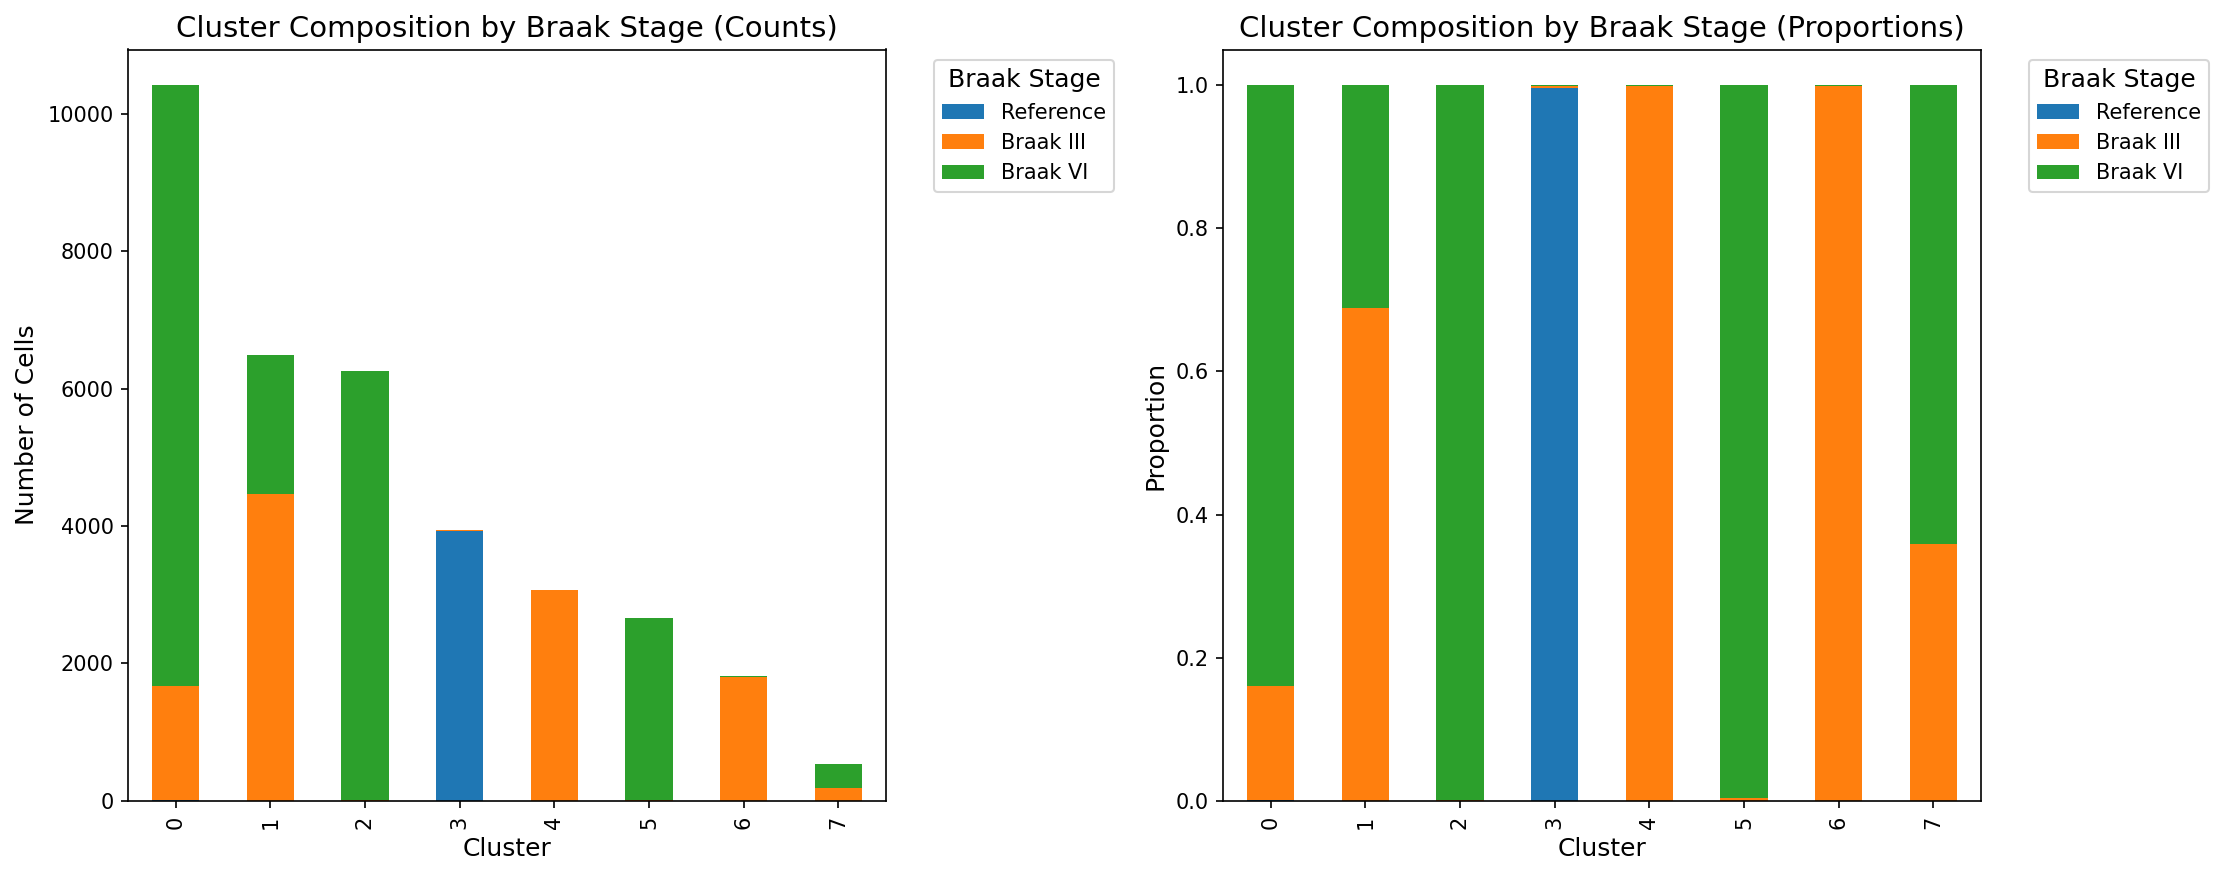


Chi-square test for cluster composition differences:
Chi-square statistic: 55769.5441
P-value: 0.0000e+00
Degrees of freedom: 14
Significant difference in cluster composition between Braak stages (p < 0.05)


In [10]:
# Analyze cluster composition by Braak stage
print("Analyzing cluster composition by Braak stage...")

if braak_col and 'leiden' in adata.obs.columns:
    # Create a cross-tabulation
    cluster_braak_crosstab = pd.crosstab(adata.obs['leiden'], adata.obs[braak_col])
    print("\nCluster composition by Braak stage:")
    print(cluster_braak_crosstab)
    
    # Calculate proportions
    cluster_braak_prop = pd.crosstab(adata.obs['leiden'], adata.obs[braak_col], normalize='index')
    print("\nCluster composition by Braak stage (proportions):")
    print(cluster_braak_prop)
    
    # Visualize cluster composition
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Absolute counts
    cluster_braak_crosstab.plot(kind='bar', ax=axes[0], stacked=True)
    axes[0].set_title('Cluster Composition by Braak Stage (Counts)')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Number of Cells')
    axes[0].legend(title='Braak Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Proportions
    cluster_braak_prop.plot(kind='bar', ax=axes[1], stacked=True)
    axes[1].set_title('Cluster Composition by Braak Stage (Proportions)')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Proportion')
    axes[1].legend(title='Braak Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical test for cluster composition differences
    from scipy.stats import chi2_contingency
    
    chi2, p_value, dof, expected = chi2_contingency(cluster_braak_crosstab)
    print(f"\nChi-square test for cluster composition differences:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4e}")
    print(f"Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print("Significant difference in cluster composition between Braak stages (p < 0.05)")
    else:
        print("No significant difference in cluster composition between Braak stages (p >= 0.05)")

else:
    print("Cannot analyze cluster composition - missing Braak stage or cluster information")


## Differential Gene Expression Analysis

Perform differential gene expression analysis between Braak stages.


In [12]:
# Perform differential gene expression analysis
print("Performing differential gene expression analysis...")

# Check if we have the necessary information
if braak_col and adata.raw is not None:
    print(f"Using Braak stage column: {braak_col}")
    print(f"Available Braak stages: {adata.obs[braak_col].unique()}")
    
    # Get unique Braak stages
    unique_braak_stages = adata.obs[braak_col].unique()
    
    # Perform pairwise comparisons
    comparisons = []
    
    # Find Reference and Braak 3/6 for comparison
    ref_stage = None
    braak3_stage = None
    braak6_stage = None
    
    for stage in unique_braak_stages:
        stage_str = str(stage)
        if stage_str == "Reference":
            ref_stage = stage
        elif stage_str == "Braak III":
            braak3_stage = stage
        elif stage_str == "Braak VI":
            braak6_stage = stage
    
    print(f"Reference stage: {ref_stage}")
    print(f"Braak III stage: {braak3_stage}")
    print(f"Braak VI stage: {braak6_stage}")
    
    # Perform comparisons using log-transformed data (not raw counts)
    if ref_stage and braak3_stage:
        print(f"\nComparing {ref_stage} vs {braak3_stage}")
        sc.tl.rank_genes_groups(adata, braak_col, groups=[braak3_stage], reference=ref_stage, 
                               method='wilcoxon', use_raw=False)  # Use log-transformed data
        comparisons.append(f"{ref_stage}_vs_{braak3_stage}")
    
    if braak3_stage and braak6_stage:
        print(f"\nComparing {braak3_stage} vs {braak6_stage}")
        sc.tl.rank_genes_groups(adata, braak_col, groups=[braak6_stage], reference=braak3_stage, 
                               method='wilcoxon', use_raw=False)  # Use log-transformed data
        comparisons.append(f"{braak3_stage}_vs_{braak6_stage}")
    
    print(f"Completed {len(comparisons)} comparisons")
    
    # Show cell counts for each stage to verify we have enough cells
    print(f"\nCell counts per Braak stage:")
    for stage in unique_braak_stages:
        count = (adata.obs[braak_col] == stage).sum()
        print(f"  {stage}: {count} cells")
    
else:
    print("Cannot perform DEG analysis - missing Braak stage information or raw data")
    print(f"Braak column: {braak_col}")
    print(f"Raw data available: {adata.raw is not None}")


Performing differential gene expression analysis...
Using Braak stage column: Braak stage
Available Braak stages: ['Braak III', 'Braak VI', 'Reference']
Categories (3, object): ['Reference', 'Braak III', 'Braak VI']
Reference stage: Reference
Braak III stage: Braak III
Braak VI stage: Braak VI

Comparing Reference vs Braak III
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:30)

Comparing Braak III vs Braak VI
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
  

## Volcano Plot Visualization

Create volcano plots to visualize the differential gene expression results.


Creating volcano plots...

Creating volcano plot for: Comparison_1_Braak VI


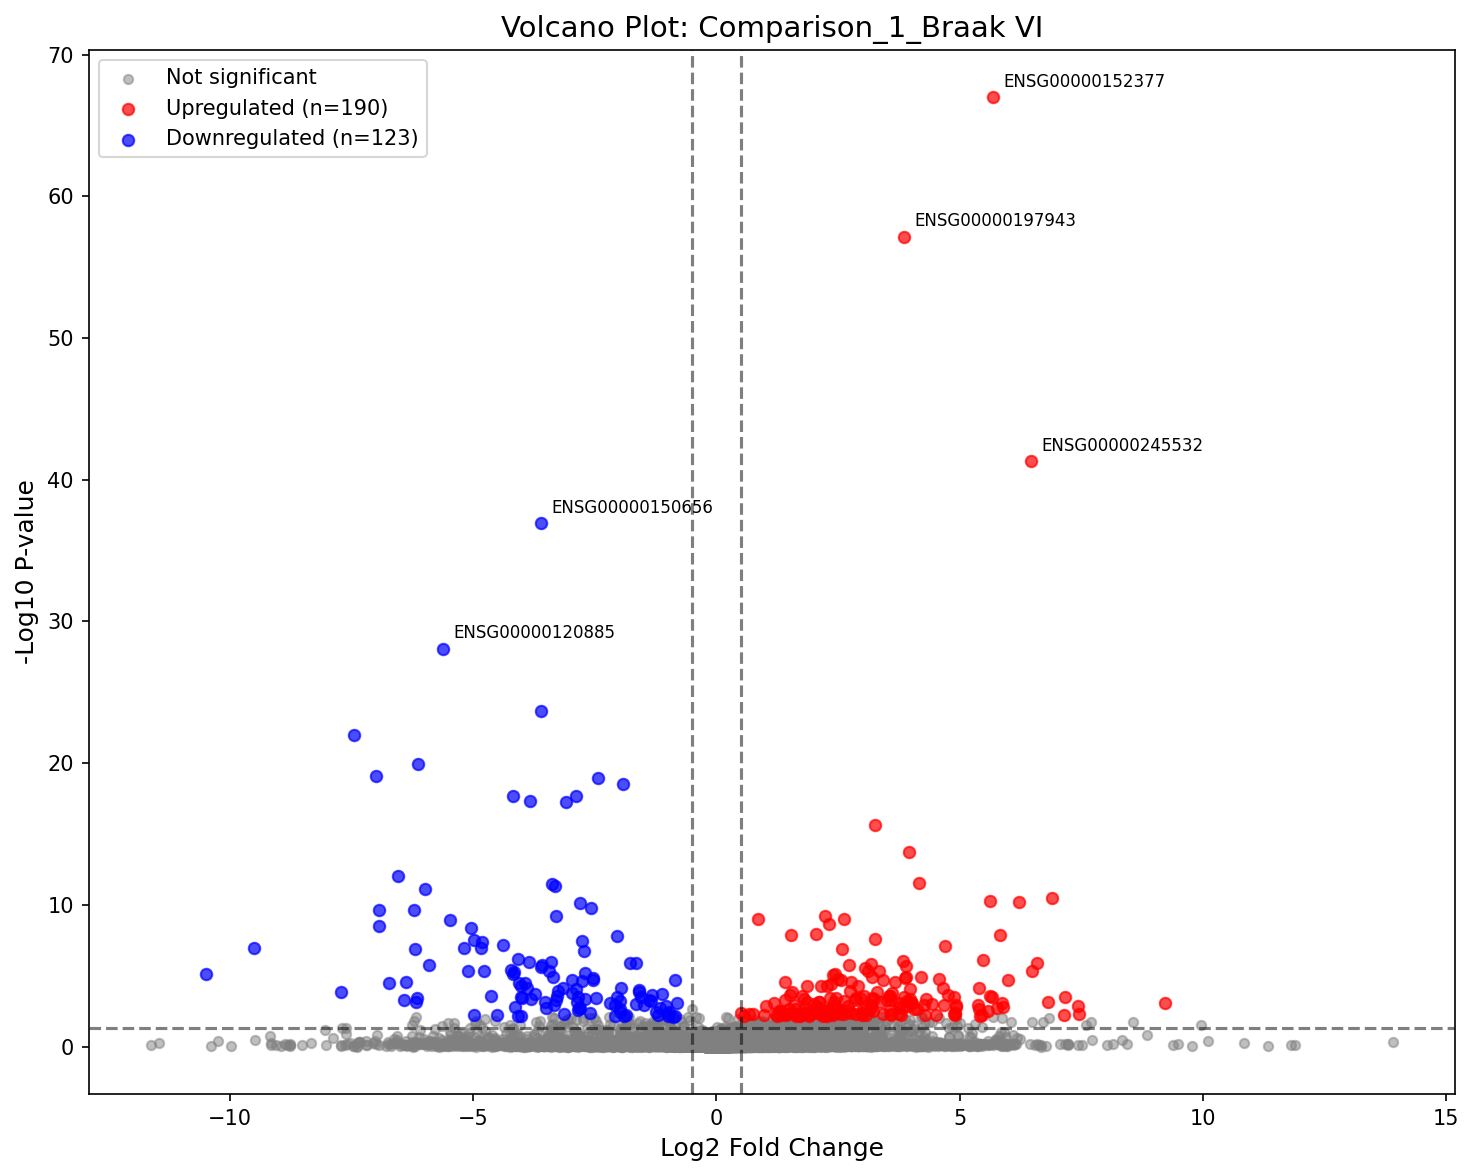


Summary for Comparison_1_Braak VI:
Total genes tested: 22894
Significantly upregulated: 190
Significantly downregulated: 123
Top 5 upregulated genes:
  ENSG00000168724: logFC=9.224, p-val=8.47e-04
  ENSG00000198089: logFC=7.453, p-val=4.68e-03
  ENSG00000133243: logFC=7.422, p-val=1.31e-03
  ENSG00000049089: logFC=7.163, p-val=3.39e-04
  ENSG00000147604: logFC=7.144, p-val=5.84e-03
Top 5 downregulated genes:
  ENSG00000114107: logFC=-10.481, p-val=8.14e-06
  ENSG00000186094: logFC=-9.492, p-val=1.05e-07
  ENSG00000166398: logFC=-7.711, p-val=1.33e-04
  ENSG00000137478: logFC=-7.439, p-val=1.00e-22
  ENSG00000249853: logFC=-6.994, p-val=8.41e-20


In [14]:
# Create volcano plots for differential gene expression results
def create_volcano_plot(adata, comparison_name, pval_thresh=0.05, logfc_thresh=0.5):
    """Create a volcano plot for differential gene expression results"""
    
    # Get the results
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    
    if len(groups) == 0:
        print(f"No groups found for comparison {comparison_name}")
        return
    
    # Get the first group (should be the comparison group)
    group = groups[0]
    
    # Extract data
    names = result['names'][group]
    logfoldchanges = result['logfoldchanges'][group]
    pvals = result['pvals'][group]
    pvals_adj = result['pvals_adj'][group]
    
    # Create DataFrame
    df = pd.DataFrame({
        'gene': names,
        'logfc': logfoldchanges,
        'pval': pvals,
        'pval_adj': pvals_adj
    })
    
    # Remove NaN values
    df = df.dropna()
    
    # Calculate -log10(p-value)
    df['neg_log10_pval'] = -np.log10(df['pval'])
    
    # Define significance
    df['significant'] = (df['pval_adj'] < pval_thresh) & (np.abs(df['logfc']) > logfc_thresh)
    df['upregulated'] = df['significant'] & (df['logfc'] > 0)
    df['downregulated'] = df['significant'] & (df['logfc'] < 0)
    
    # Create volcano plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot non-significant genes
    ax.scatter(df[~df['significant']]['logfc'], 
               df[~df['significant']]['neg_log10_pval'], 
               c='gray', alpha=0.5, s=20, label='Not significant')
    
    # Plot upregulated genes
    if df['upregulated'].sum() > 0:
        ax.scatter(df[df['upregulated']]['logfc'], 
                   df[df['upregulated']]['neg_log10_pval'], 
                   c='red', alpha=0.7, s=30, label=f'Upregulated (n={df["upregulated"].sum()})')
    
    # Plot downregulated genes
    if df['downregulated'].sum() > 0:
        ax.scatter(df[df['downregulated']]['logfc'], 
                   df[df['downregulated']]['neg_log10_pval'], 
                   c='blue', alpha=0.7, s=30, label=f'Downregulated (n={df["downregulated"].sum()})')
    
    # Add threshold lines
    ax.axhline(y=-np.log10(pval_thresh), color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=logfc_thresh, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-logfc_thresh, color='black', linestyle='--', alpha=0.5)
    
    # Labels and title
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 P-value')
    ax.set_title(f'Volcano Plot: {comparison_name}')
    ax.legend()
    
    # Add gene labels for top genes
    top_genes = df.nlargest(5, 'neg_log10_pval')
    for _, row in top_genes.iterrows():
        ax.annotate(row['gene'], (row['logfc'], row['neg_log10_pval']), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for {comparison_name}:")
    print(f"Total genes tested: {len(df)}")
    print(f"Significantly upregulated: {df['upregulated'].sum()}")
    print(f"Significantly downregulated: {df['downregulated'].sum()}")
    print(f"Top 5 upregulated genes:")
    top_up = df[df['upregulated']].nlargest(5, 'logfc')
    for _, row in top_up.iterrows():
        print(f"  {row['gene']}: logFC={row['logfc']:.3f}, p-val={row['pval']:.2e}")
    
    print(f"Top 5 downregulated genes:")
    top_down = df[df['downregulated']].nsmallest(5, 'logfc')
    for _, row in top_down.iterrows():
        print(f"  {row['gene']}: logFC={row['logfc']:.3f}, p-val={row['pval']:.2e}")
    
    return df

# Create volcano plots for each comparison
if 'rank_genes_groups' in adata.uns:
    print("Creating volcano plots...")
    
    # Create plots for each comparison
    volcano_results = {}
    
    # Get the most recent comparison results
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    
    for i, group in enumerate(groups):
        comparison_name = f"Comparison_{i+1}_{group}"
        print(f"\nCreating volcano plot for: {comparison_name}")
        
        # Create a temporary adata with just this comparison
        temp_adata = adata.copy()
        temp_result = {
            'names': result['names'][[group]],
            'logfoldchanges': result['logfoldchanges'][[group]],
            'pvals': result['pvals'][[group]],
            'pvals_adj': result['pvals_adj'][[group]]
        }
        temp_adata.uns['rank_genes_groups'] = temp_result
        
        volcano_df = create_volcano_plot(temp_adata, comparison_name)
        volcano_results[comparison_name] = volcano_df
        
else:
    print("No differential gene expression results found for volcano plots")


In [16]:
adata.var['feature_name'].head()

ENSG00000000003      TSPAN6
ENSG00000000005        TNMD
ENSG00000000419        DPM1
ENSG00000000457       SCYL3
ENSG00000000460    C1orf112
Name: feature_name, dtype: category
Categories (36392, object): ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', ..., 'ZZEF1', 'ZZZ3', 'hsa-mir-1253', 'hsa-mir-423']

## Save Results

Create output folder and save all analysis results.


In [ ]:
# Create output directory
output_dir = Path("../output")
output_dir.mkdir(exist_ok=True)
print(f"Output directory: {output_dir.absolute()}")

# Save the processed AnnData object
processed_data_path = output_dir / "processed_DLPFC_SEA-AD_oligos.h5ad"
adata.write(processed_data_path)
print(f"Saved processed data to: {processed_data_path}")

# Save cluster composition results
if braak_col and 'leiden' in adata.obs.columns:
    cluster_braak_crosstab.to_csv(output_dir / "cluster_braak_composition_counts.csv")
    cluster_braak_prop.to_csv(output_dir / "cluster_braak_composition_proportions.csv")
    print("Saved cluster composition tables")

# Save differential gene expression results
if 'rank_genes_groups' in adata.uns:
    # Convert rank_genes_groups to DataFrame and save
    result = adata.uns['rank_genes_groups']
    
    # Save each comparison separately
    for group in result['names'].dtype.names:
        comparison_name = f"deg_results_{group}"
        
        # Create DataFrame for this comparison
        deg_df = pd.DataFrame({
            'gene': result['names'][group],
            'logfc': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'scores': result['scores'][group] if 'scores' in result else None
        })
        
        # Save to CSV
        deg_path = output_dir / f"{comparison_name}.csv"
        deg_df.to_csv(deg_path, index=False)
        print(f"Saved DEG results to: {deg_path}")

print("All results saved successfully!")


## Summary

This notebook has completed the following analyses:

1. ✅ Loaded and inspected the OLIGO_DLPFC_SEA-AD.h5ad dataset
2. ✅ Checked data normalization status and raw data availability
3. ✅ Filtered data for Braak stages: Reference, Braak 3, and Braak 6
4. ✅ Performed standard Scanpy processing (if raw counts detected)
5. ✅ Analyzed cluster composition by Braak stage with statistical testing
6. ✅ Performed differential gene expression analysis between Braak stages
7. ✅ Created volcano plots for visualization
8. ✅ Saved all results to the output folder

### Key Files Generated:
- `processed_DLPFC_SEA-AD_oligos.h5ad`: Processed AnnData object
- `cluster_braak_composition_counts.csv`: Cluster composition counts
- `cluster_braak_composition_proportions.csv`: Cluster composition proportions
- `deg_results_[comparison].csv`: Differential gene expression results for each comparison

### Next Steps:
- Review the volcano plots for biologically relevant genes
- Perform pathway enrichment analysis on significant DEGs
- Validate findings with additional datasets or experimental approaches
